In [1]:
# Set parent path for imports.

import os
import sys

# Get desired path:
path = os.path.dirname(os.path.dirname(os.getcwd()))

# Add the parent directory to sys.path
sys.path.append(path)

In [2]:
import numpy as np

from statespace.models import BrownianLangevinModel
from statespace.models import NVMLangevinModel

from stochastic.processes import GammaProcess
from stochastic.processes import GeneralisedInverseGaussianProcess

from statespace.methods import KalmanFilter, SequentialCollapsedGaussianMCMCFilter

import pandas as pd
import matplotlib.pyplot as plt

# Generate data:

In [3]:
T = np.linspace(0, 100, num=200).reshape(-1, 1)
#T = np.linspace(0, 100, num=1000).reshape(-1, 1)

# Define Student-t process:
lam = -2.5
delta = np.sqrt(-2 * lam)

gig_process_params = {"lam":lam, "gamma":0, "delta":delta}
generative_subordinator = GeneralisedInverseGaussianProcess(**gig_process_params)

# Define model
generative_state_shape = (2,1)

generative_theta = -0.2
generative_mu = 0.
generative_sigma = 1.
generative_sigma_eps = 0.1

generative_model = NVMLangevinModel(subordinator=generative_subordinator,
                                    theta=generative_theta,
                                    mu=generative_mu,
                                    sigma=generative_sigma,
                                    sigma_eps=generative_sigma_eps,
                                    shape=generative_state_shape
                                   )

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to GIG paper version.
The dominating point process is set as a stable process.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


In [4]:
# Print parameter values:
generative_model.get_parameter_values()

{'theta': -0.2, 'mu': 0.0, 'sigma': 1.0, 'sigma_eps': 0.1}

In [5]:
x, y = generative_model.sample(times=T)

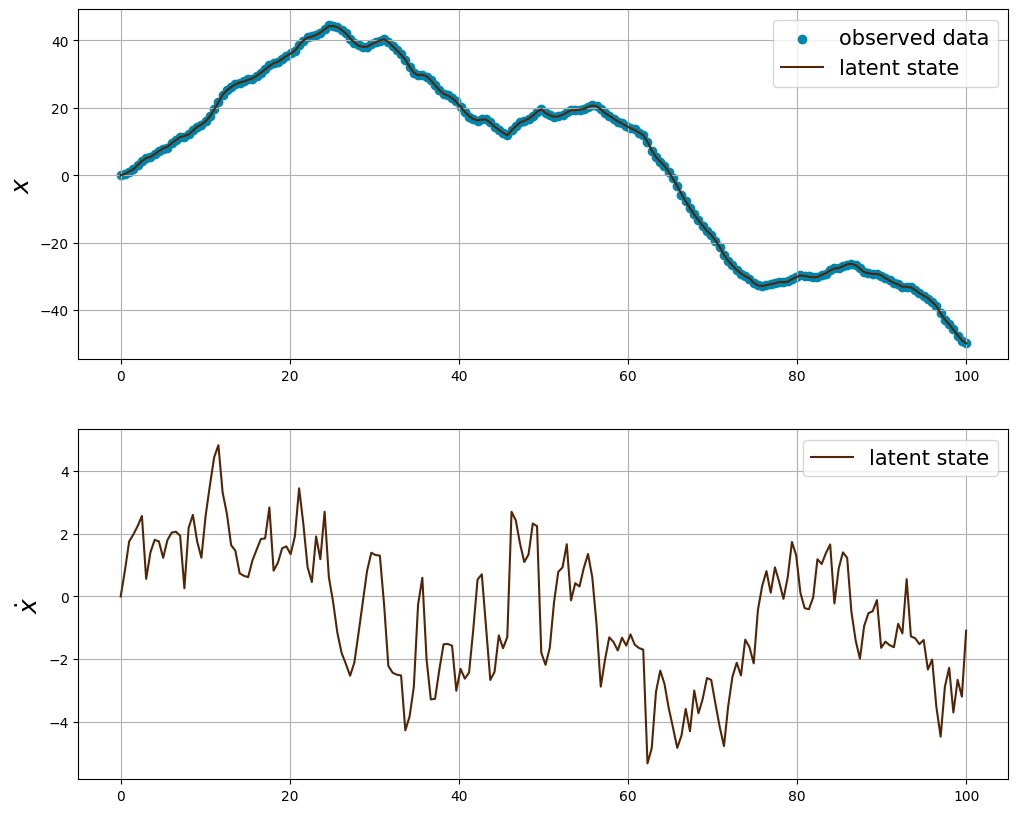

In [6]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

# Inference

Given an array of time points T, and observations y, estimate the states (and parameters).

## Kalman filtering given true subordinator jumps:

In [7]:
state_shape = (2,1)

# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=state_shape)

P_init = np.random.normal(loc=0., scale=1., size=(state_shape[0], state_shape[0]))
P_init = np.matmul(P_init.T, P_init)

In [8]:
inference_method = KalmanFilter(model=generative_model, prior=None, proposal=None)

The prior configuration is not valid.


In [9]:
history = inference_method.filter(times=T, y=y, x_init=x_init, P_init=P_init)

In [10]:
x_est = inference_method.x_est
P_est = inference_method.P_est

post_vars = np.array([np.diag(COV) for COV in P_est[1:,:,:]])
predictive_vars = post_vars + inference_method.model.eps.covariance()

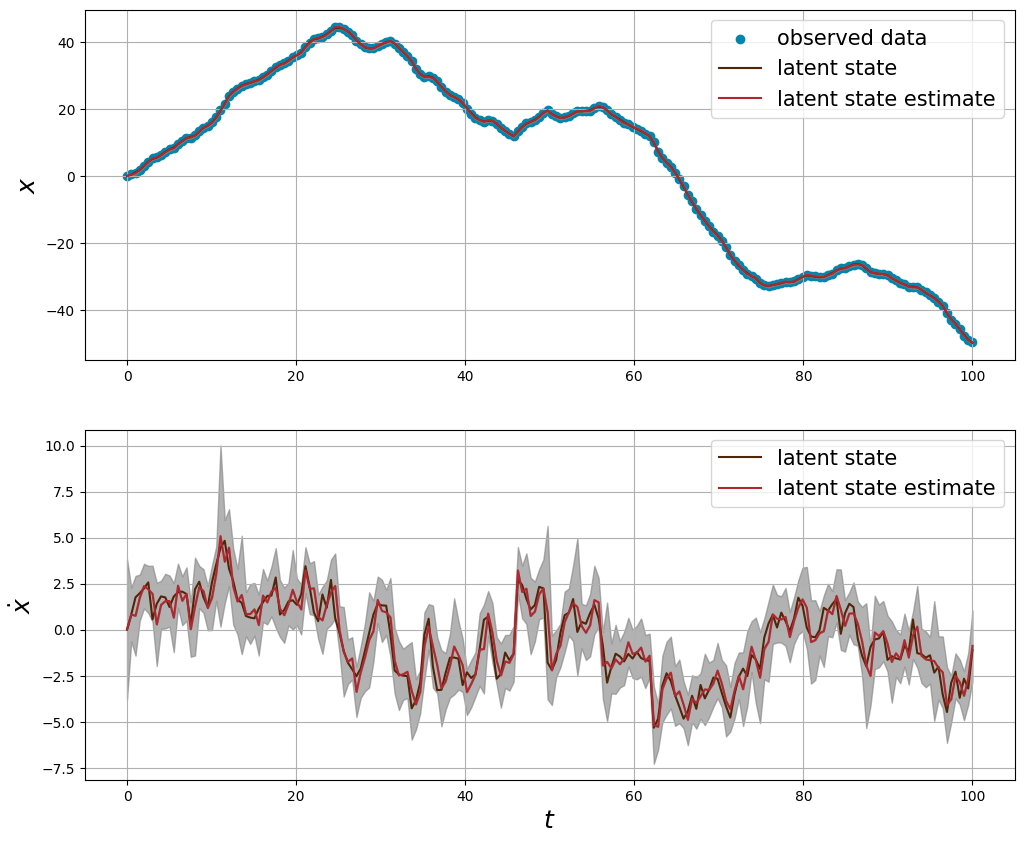

In [11]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, x_est[1:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.7)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.7)

# Plot predictive uncertainty:
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(predictive_vars[:, 0]), color='grey', alpha=0.4)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(predictive_vars[:, 0]), color='grey', alpha=0.4)

# Settings:
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, x_est[1:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() + 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() - 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)

# Settings:
ax[1].set_xlabel(r"$t$", fontsize=18)
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

In [12]:
# Compute basic results:

observation_space_latent_error = x_est[1:,0,:] - x[:,0]
latent_space_error = x_est[1:,1,:] - x[:,1]

# Compute MAPE:

observation_space_percentage_error = (observation_space_latent_error/x[:,0])
observation_space_percentage_error = observation_space_percentage_error[np.isfinite(observation_space_percentage_error)]

observation_space_mape = np.abs(observation_space_percentage_error).sum() / observation_space_percentage_error.size
print(f"Observation space MAPE of state: {observation_space_mape}")

latent_space_percentage_error = (latent_space_error/x[:,1])
latent_space_percentage_error = latent_space_percentage_error[np.isfinite(latent_space_percentage_error)]

latent_space_mape = np.abs(latent_space_percentage_error).sum() / latent_space_percentage_error.size
print(f"Latent space MAPE of state: {latent_space_mape}")

# Compute MSE:

observation_space_mse = (observation_space_latent_error**2).sum() / observation_space_latent_error.size
print(f"Observation space MSE of state: {observation_space_mse}")

latent_space_mse = (latent_space_error**2).sum() / latent_space_error.size
print(f"Latent space MSE of state: {latent_space_mse}")

Observation space MAPE of state: 0.007229340197136359
Latent space MAPE of state: 0.6225190877748362
Observation space MSE of state: 0.010488778243937426
Latent space MSE of state: 0.4049300172483558


/var/folders/kz/7d9nbyzs2hs58pn0w3f1v5880000gn/T/ipykernel_13235/216733359.py:8: RuntimeWarning: divide by zero encountered in divide
  observation_space_percentage_error = (observation_space_latent_error/x[:,0])
/var/folders/kz/7d9nbyzs2hs58pn0w3f1v5880000gn/T/ipykernel_13235/216733359.py:14: RuntimeWarning: divide by zero encountered in divide
  latent_space_percentage_error = (latent_space_error/x[:,1])


## Kalman filtering with a Brownian motion:

In [13]:
state_shape = (2,1)

theta = -0.2
sigma = 1.
sigma_eps = 0.1

model = BrownianLangevinModel(theta=theta, sigma=sigma, sigma_eps=sigma_eps, shape=state_shape)
model.get_parameter_values()

{'theta': -0.2, 'sigma': 1.0, 'sigma_eps': 0.1}

In [14]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=state_shape)

P_init = np.random.normal(loc=0., scale=1., size=(state_shape[0], state_shape[0]))
P_init = np.matmul(P_init.T, P_init)

In [15]:
inference_method = KalmanFilter(model=model, prior=None, proposal=None)
history = inference_method.filter(times=T, y=y, x_init=x_init, P_init=P_init)

The prior configuration is not valid.


In [16]:
x_est = inference_method.x_est
P_est = inference_method.P_est

post_vars = np.array([np.diag(COV) for COV in P_est[1:,:,:]])
predictive_vars = post_vars + inference_method.model.eps.covariance()

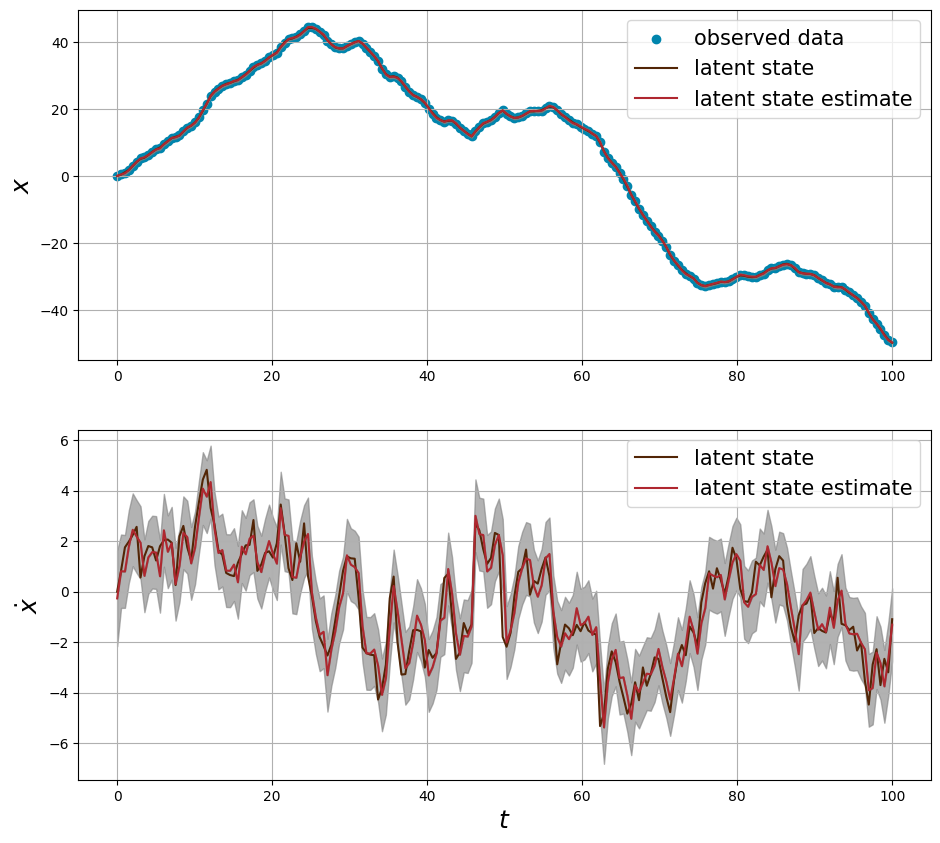

In [17]:
fig, ax = plt.subplots(nrows=2, figsize=(11,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, x_est[1:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.7)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.7)

# Plot predictive uncertainty:
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(predictive_vars[:, 0]), color='grey', alpha=0.4)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(predictive_vars[:, 0]), color='grey', alpha=0.4)

# Settings:
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, x_est[1:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() + 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() - 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)

# Settings:
ax[1].set_xlabel(r"$t$", fontsize=18)
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

In [18]:
# Compute basic results:

observation_space_latent_error = x_est[1:,0,:] - x[:,0]
latent_space_error = x_est[1:,1,:] - x[:,1]

# Compute MAPE:

observation_space_percentage_error = (observation_space_latent_error/x[:,0])
observation_space_percentage_error = observation_space_percentage_error[np.isfinite(observation_space_percentage_error)]

observation_space_mape = np.abs(observation_space_percentage_error).sum() / observation_space_percentage_error.size
print(f"Observation space MAPE of state: {observation_space_mape}")

latent_space_percentage_error = (latent_space_error/x[:,1])
latent_space_percentage_error = latent_space_percentage_error[np.isfinite(latent_space_percentage_error)]

latent_space_mape = np.abs(latent_space_percentage_error).sum() / latent_space_percentage_error.size
print(f"Latent space MAPE of state: {latent_space_mape}")

# Compute MSE:

observation_space_mse = (observation_space_latent_error**2).sum() / observation_space_latent_error.size
print(f"Observation space MSE of state: {observation_space_mse}")

latent_space_mse = (latent_space_error**2).sum() / latent_space_error.size
print(f"Latent space MSE of state: {latent_space_mse}")

Observation space MAPE of state: 0.006913683639387352
Latent space MAPE of state: 0.6220047603117761
Observation space MSE of state: 0.010493469533244143
Latent space MSE of state: 0.43660115374110586


/var/folders/kz/7d9nbyzs2hs58pn0w3f1v5880000gn/T/ipykernel_13235/216733359.py:8: RuntimeWarning: divide by zero encountered in divide
  observation_space_percentage_error = (observation_space_latent_error/x[:,0])
/var/folders/kz/7d9nbyzs2hs58pn0w3f1v5880000gn/T/ipykernel_13235/216733359.py:14: RuntimeWarning: divide by zero encountered in divide
  latent_space_percentage_error = (latent_space_error/x[:,1])


## Sequential Collapsed Gaussian MCMC Filter:

In [19]:
# Define Student-t process:
lam = -2.5
delta = np.sqrt(-2 * lam)

gig_process_params = {"lam":lam, "gamma":0, "delta":delta}
subordinator = GeneralisedInverseGaussianProcess(**gig_process_params)
# subordinator = GammaProcess(**gamma_process_params)

# Define model
state_shape = (2,1)

theta = -0.2
mu = 0.
sigma = 1.
sigma_eps = 0.1

model = NVMLangevinModel(subordinator=subordinator,
                         theta=theta,
                         mu=mu,
                         sigma=sigma,
                         sigma_eps=sigma_eps,
                         shape=state_shape
                        )
model.get_parameter_values()

Residual approximation mode is set to Gaussian approximation.
Simulation method is set to GIG paper version.
The dominating point process is set as a stable process.
Residual approximation method is set to lower bounding method.
Residual approximation mode is set to Gaussian approximation.
Residual approximation mode is set to Gaussian approximation.


{'theta': -0.2, 'mu': 0.0, 'sigma': 1.0, 'sigma_eps': 0.1}

In [20]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=state_shape)

P_init = np.random.normal(loc=0., scale=1., size=(state_shape[0], state_shape[0]))
P_init = np.matmul(P_init.T, P_init)

In [21]:
inference_method = SequentialCollapsedGaussianMCMCFilter(model=model, prior=None, proposal=None)

The prior configuration is not valid.


In [22]:
history = inference_method.filter(times=T, y=y, x_init=x_init, P_init=P_init, n_samples=100, burn_in=30)

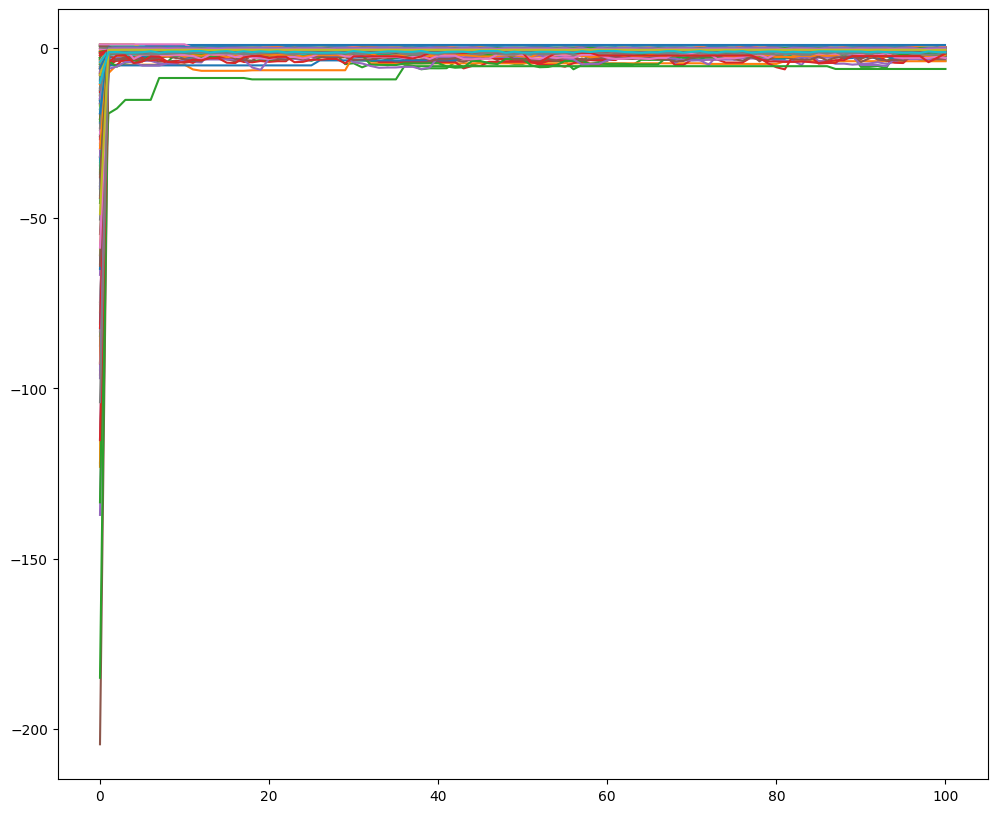

In [23]:
# Log marginal likelihood for each individual iteration

fig, ax = plt.subplots(figsize=(12,10))

ax.plot(np.array(inference_method.log_evidence)[:,:,0,0].T)

plt.show()

In [24]:
x_est = inference_method.x_est
P_est = inference_method.P_est

post_vars = np.array([np.diag(COV) for COV in P_est[1:,:,:]])
predictive_vars = post_vars + inference_method.model.eps.covariance()

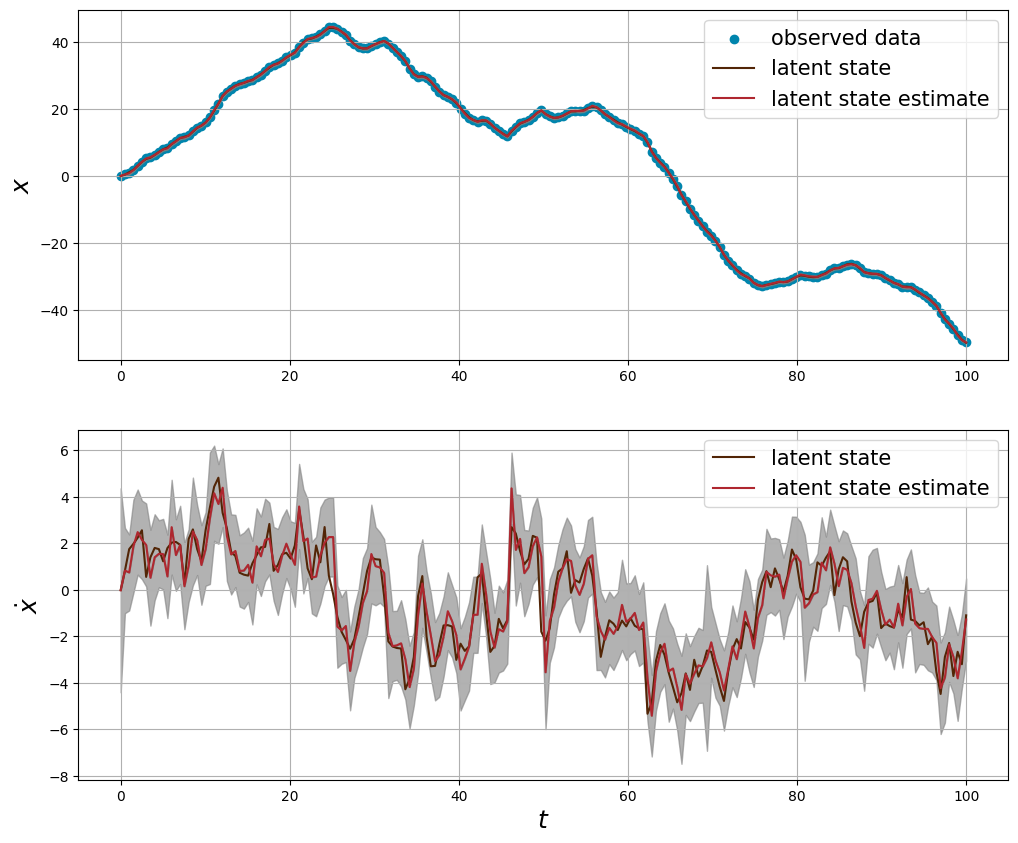

In [25]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, x_est[1:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.7)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.7)

# Plot predictive uncertainty:
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(predictive_vars[:, 0]), color='grey', alpha=0.4)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(predictive_vars[:, 0]), color='grey', alpha=0.4)

# Settings:
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, x_est[1:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() + 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() - 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)

# Settings:
ax[1].set_xlabel(r"$t$", fontsize=18)
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

In [26]:
# Compute basic results:

observation_space_latent_error = x_est[1:,0,:] - x[:,0]
latent_space_error = x_est[1:,1,:] - x[:,1]

# Compute MAPE:

observation_space_percentage_error = (observation_space_latent_error/x[:,0])
observation_space_percentage_error = observation_space_percentage_error[np.isfinite(observation_space_percentage_error)]

observation_space_mape = np.abs(observation_space_percentage_error).sum() / observation_space_percentage_error.size
print(f"Observation space MAPE of state: {observation_space_mape}")

latent_space_percentage_error = (latent_space_error/x[:,1])
latent_space_percentage_error = latent_space_percentage_error[np.isfinite(latent_space_percentage_error)]

latent_space_mape = np.abs(latent_space_percentage_error).sum() / latent_space_percentage_error.size
print(f"Latent space MAPE of state: {latent_space_mape}")

# Compute MSE:

observation_space_mse = (observation_space_latent_error**2).sum() / observation_space_latent_error.size
print(f"Observation space MSE of state: {observation_space_mse}")

latent_space_mse = (latent_space_error**2).sum() / latent_space_error.size
print(f"Latent space MSE of state: {latent_space_mse}")

Observation space MAPE of state: 0.007308516596233256
Latent space MAPE of state: 0.6929999185012429
Observation space MSE of state: 0.010508483786530545
Latent space MSE of state: 0.4802011553802895


/var/folders/kz/7d9nbyzs2hs58pn0w3f1v5880000gn/T/ipykernel_13235/216733359.py:8: RuntimeWarning: divide by zero encountered in divide
  observation_space_percentage_error = (observation_space_latent_error/x[:,0])
/var/folders/kz/7d9nbyzs2hs58pn0w3f1v5880000gn/T/ipykernel_13235/216733359.py:14: RuntimeWarning: divide by zero encountered in divide
  latent_space_percentage_error = (latent_space_error/x[:,1])
